## Mean Shift Clustering Algorithm

Implementing and testing the MSC algorithm using the Epanechnikov Kernel. MSC is a non-parametric mode seeking algorithm that discovers clusters by finding the local maxima (modes) of a density function estimated from the data points. 

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import torch

### E. Kernel

Epanechnikov Kernel between 2 points $x_i$ and $x_j$. 

$$ K(|| x_i - x_j ||) = \max{(0, 1 - \frac{|| x_i - x_j ||^2}{h^2})} $$

The point of a kernel is to score the distance for each neighbor $x_j$ of point $x_i$. Closer points get a weight near 1, and farther points get a smaller weight, tapering off at the kernel's radius $h$. Epanechnikov is a finite-support kernel, so points beyond the radius get weight 0. The kernel smoothly emphasizes closer points and ignores farther points instead of averaging over all points within a hard cutoff.

$p(x_i)$ is proportional to the true KDE (Kernel density estimate) where 

$$ p(x_i) = \Sigma_{j=1}^{N} K(|| x_i - x_j ||) $$

it is not directly equal to this term because the True KDE is proper probability density function and would require a normalization constant C so that it integrates to 1. But we don't care about this because mean-shift clustering only cares about relative density values for comparison. At each mean-shift step, points are "pulled" towards local high-density regions. BTW, it can be shown that this weighted update step points in the direction of density gradient.  

In [164]:
def epanechnikov_kernel(r: torch.Tensor, h: torch.Tensor):
    """
    Args:
        r: tensor of pairwise differences of shape N x N x D
        h: bandwidth (kernel radius)
    Returns
        ep. kernel
    """

    dist2 = (r ** 2).sum(r.dim() - 1) # squared l2 norm of each coordinate: [N x N]
    return torch.clamp(1.0 - (dist2 / (h ** 2)), min=0.0) # [N x N]


In [165]:
h = 1.0
d = torch.linspace(0, 1.5 * h, steps=200)
r = d.view(200, 1) # since we sum over the column dimension in the kernel function
K = epanechnikov_kernel(r, torch.tensor(h))
d.shape, r.shape, K.shape


(torch.Size([200]), torch.Size([200, 1]), torch.Size([200]))

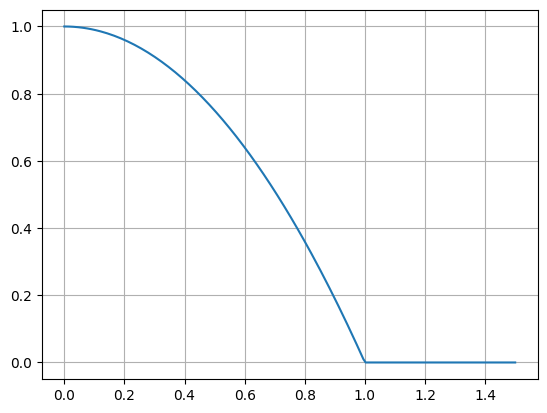

In [166]:
plt.plot(d.numpy(), K.numpy())
plt.grid(True)
plt.show()

### Mean-Shift Clustering

Repeat

$$ 

x_i = \frac{\Sigma_{j=1}^{N} a_j * K(|| x_i - x_j ||) * q_i}{\Sigma_{j=1}^{N} a_j * K(|| x_i - x_j ||)}

$$

for each $x_i$ for max iters or a tolerance

In [167]:
def mean_shift_update_step(x: torch.Tensor, 
                           a: torch.Tensor,
                           h: torch.Tensor):

    # x: [N x 3] points
    # a: [N] attention weights
    # h: bandwidth (kernel radius)

    N, D = x.shape

    # [N, N, 3] = [N, 1, 3] - [1, N, 3]: x[i] - x[j] pairwise matrix
    diff = x.unsqueeze(dim=1) - x.unsqueeze(dim=0)
    K = epanechnikov_kernel(diff, h)

    # a: [N, ]
    # K: [N, N]
    # Understanding K: Each row index i in K corresponds to the ith vertex
    # Each row-column index i,j corresponds to K(x_i - x_j)
    # So each row represents the Kernel values for each x_j for a fixed x_i
    # Each of these values need to be weighted by their vertex attention
    # So we need a_j * K(x_i - x_j), which means multiplying the a tensor to each row element wise.
    # Which means, duplicate a for each row. 
    w = K * a.view(1, N) # broadcast a[j] across each row i

    # For each point x_i,
    # The new value is the weighted average of w_ij * x_j
    # Essentially, we are multiplying each x_j by its affect on x_i,
    # and this "affect" is computed as the a_j * K(x_j - x_i)
    # This corresponds to taking the dot prod of row i in w with vertex i in x
    # Do this for each row, which corresponds to the matrix mult. w @ x
    numerator = w @ x # [N x 3]

    # Sum across columns (dimension 1)
    denominator = w.sum(dim=1, keepdim=True) # N x 1

    # avoid divison by zero
    eps = 1e-8 
    x_next = numerator / (denominator + eps)

    return x_next


In [168]:
def mean_shift_clustering(vertices: torch.Tensor, 
                          attention: torch.Tensor, 
                          h: float = 1.0,
                          tol: float = 1e-3, 
                          max_iters: int = 50) -> torch.Tensor:
    x = vertices.clone()
    N, _ = x.shape

    for _ in range(max_iters):
        x_next = mean_shift_update_step(x, attention, h)
        # Norm gives us the magnitude of the point's shift
        if torch.max((x_next - x).norm(dim=1)) < tol:
            break
        x = x_next
    return x

### Mode Extraction

We use density based mode extraction

1. Compute Density (Same as denominator in mean shift clustering)

$$ p_i = \Sigma_{j=1}^{N} a_j * K(|| x_i - x_j ||) $$

2. Suppression Loop for extracting modes
    - Keep a unused boolean mask of unusued point indices. Unused as in points that have not yet been chosen as cluster centers
    - At each iteration, mask out points by setting their density to $-\infty$
    - Take the argmax to find the highest density point x_i amongst all unused points
    - Add this maximum density point to our list of found modes
    - "remove" indices j where euclidean_dist(x_j, x_i) is less than h (remove by setting corresponding indices in unused to false)
    - Repeat until all indices have been used
3. Returns tensor of shape M x D where M is the number of cluster centers (modes)

In [ ]:
def mode_extraction(vertices: torch.Tensor, 
                    attention: torch.Tensor,
                    h: torch.Tensor,
                    densities: torch.Tensor = None):

    # "blurring-sharpening" mode detection

    x = vertices
    a = attention

    N, D = x.shape

    # This is equivalent to the denominator at the iteration of mean-shift clustering
    if not densities:
        diff = x.unsqueeze(1) - x.unsqueeze(0)
        K = epanechnikov_kernel(diff, h)
        w = a.view(1, N) * K
        densities = w.sum(dim=1)
    
    # Calculate all pairwise Euclidean distances for suppression
    # (After picking a mode, we suppress all points within radius h of the mode)
    dist = torch.sqrt((diff * diff).sum(dim=2))   # [N, N]

    # Mode selection
    unused_mask = torch.ones(N, dtype=torch.bool)  # True = still available
    modes = []

    while unused_mask.any():
        # Mask out used points by setting their density to -inf
        masked_density = densities.masked_fill(~unused_mask, float('-inf'))
        # Pick highest-density among unused
        i_star = torch.argmax(masked_density).item()
        modes.append(x[i_star])

        # Suppress all points within h of the chosen mode
        # dist[i_star] is a [N] vector of distances from i_star
        suppress = dist[i_star] <= h
        
        # Update the unused_mask in one vectorized op
        unused_mask = unused_mask & (~suppress)

    return torch.stack(modes, dim=0) if modes else torch.empty((0, D))



### Testing

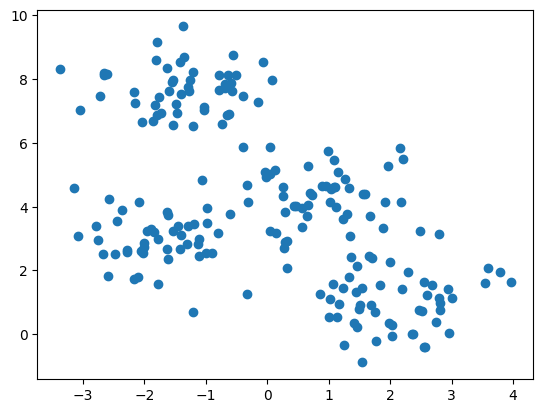

In [170]:
np.random.seed(0)
points_np, _ = make_blobs(n_samples=200, centers=4, cluster_std=0.8)
points = torch.tensor(points_np, dtype=torch.float32)

N, D = points.shape
attention = torch.ones(N)

points.shape

plt.scatter(points_np[:, 0], points_np[:, 1])

In [171]:
h = 2
# High h: underfitting
# Low h: overfitting
moved = mean_shift_clustering(points, attention, h=h, tol=1e-3, max_iters=1)
moved.shape
moved.round(decimals=4).unique(dim=0)

tensor([[-2.5427e+00,  7.9535e+00],
        [-2.5086e+00,  3.8277e+00],
        [-2.2070e+00,  3.0110e+00],
        [-2.1691e+00,  7.3830e+00],
        [-2.1000e+00,  3.1218e+00],
        [-2.0861e+00,  3.4693e+00],
        [-2.0614e+00,  2.9598e+00],
        [-2.0605e+00,  2.5429e+00],
        [-2.0263e+00,  2.8078e+00],
        [-1.9834e+00,  7.8375e+00],
        [-1.9816e+00,  7.7977e+00],
        [-1.9761e+00,  7.5374e+00],
        [-1.9624e+00,  2.8187e+00],
        [-1.9580e+00,  3.1548e+00],
        [-1.9465e+00,  7.8072e+00],
        [-1.9413e+00,  3.2919e+00],
        [-1.9181e+00,  2.5165e+00],
        [-1.9049e+00,  2.8670e+00],
        [-1.9046e+00,  2.8530e+00],
        [-1.8876e+00,  2.5484e+00],
        [-1.8437e+00,  2.8706e+00],
        [-1.8423e+00,  2.8509e+00],
        [-1.8410e+00,  2.8698e+00],
        [-1.8280e+00,  2.9054e+00],
        [-1.8266e+00,  3.3996e+00],
        [-1.8226e+00,  2.9425e+00],
        [-1.8003e+00,  3.0577e+00],
        [-1.7765e+00,  3.078

In [172]:
unique_modes = mode_extraction(moved, attention, h=h)
unique_modes.shape

torch.Size([4, 2])

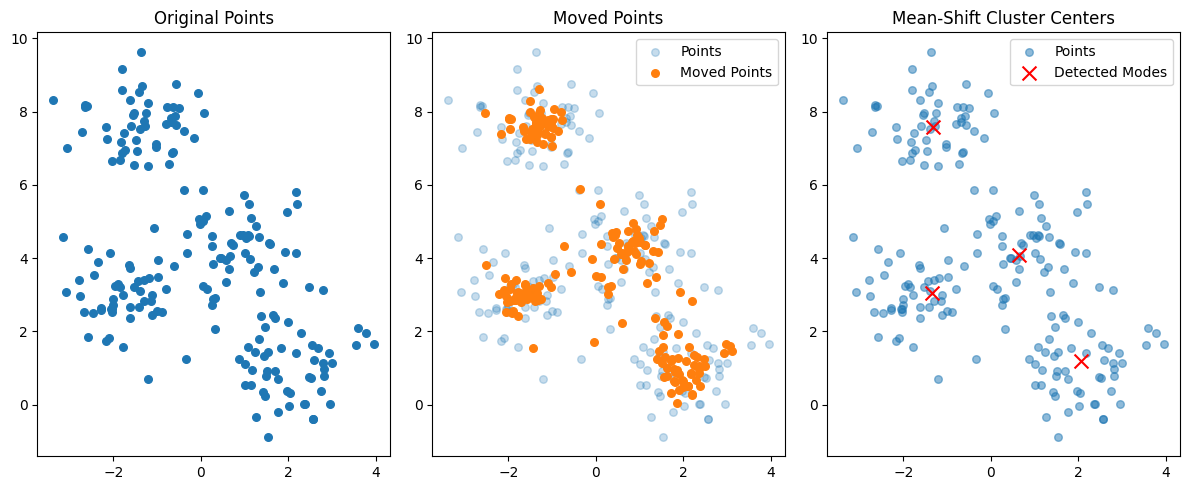

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.scatter(points_np[:,0], points_np[:,1], s=30)
plt.title("Original Points")

plt.subplot(1, 3, 2)
plt.scatter(points_np[:,0], points_np[:,1], s=30, alpha=0.25, label="Points")
plt.scatter(moved[:, 0], moved[:, 1], s=30, label="Moved Points")
plt.title("Moved Points")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(points_np[:,0], points_np[:,1], s=30, alpha=0.5, label="Points")
plt.scatter(unique_modes[:,0], unique_modes[:,1], color='red', s=100, marker='x', label="Detected Modes")
plt.title("Mean‑Shift Cluster Centers")
plt.legend()

plt.tight_layout()
plt.show()